In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os, sys

#sys.path.append(os.path.expanduser("~/Dropbox/ROZ/code/pyCRM"))
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
from pyCRM import CRM
#from pyCRM.CRM import CRM

sns.set()
DATA_DIR = "../data/"
OUT_DIR = "../results/"

In [3]:
inj = pd.read_csv(DATA_DIR + "injection_Senlac.csv")
prod = pd.read_csv(DATA_DIR + "production_Senlac.csv")
injection = inj.values
production = prod.values
time = pd.read_csv(DATA_DIR + "time_Senlac.csv").values[:, 0]

production.shape

(132, 23)

# Naive initial guess

In [4]:
%%time
constrainer = "sum-to-one injector"
crm = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")

# crm.fit(
#     production,
#     injection,
#     time,
#     method="trust-constr",
#     options={"disp": True, "maxiter": 3000},
#     random=False,
# )

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 12.6 µs


# Using homogeneous field initial guess
### As relayed by Jerry L Jensen

Assumptions: uniform porosity and permeability in a rectangular system at pseudosteady state. This is based on Valkó and others, 2000, "Development and application of the multiwell productivity index (MPI)," SPEJ, v.5(1) pp. 21-31, denoted herein as VDB. Another source is Kaviani and Jensen, 2010, "Reliable connectivity evaluation in conventional and heavy oil reservoirs: A case study from Senlac heavy oil pool, western Saskatchewan," SPE 137504, 20p., or KJ for short.  

From Eq A.3 from KJ, we have
$$
{\bf\Lambda} = \frac{1}{{\bf 1}_{IK}{\bf A}_{prod}^{-1} {\bf 1}_{KI}} {\bf A}_{prod}^{-1}
\left({\bf 1}_{KK}{\bf A}_{prod}^{-1}{\bf A}_{con}^{T} - {\bf 1}_{K1} \right)
- {\bf A}_{prod}^{-1} {\bf A}_{con}^{T} 
$$
where $K$ is the number of producer, $I$ is the number of injectors, ${\bf A}_{prod}$ is the producer-producer influence matrix, ${\bf A}_{con}$ is the injector-producer influence matrix, and we are solving for the injector-to-producer connectivity ${\bf\Lambda}$.

We use VDB's assumption that this is a rectangular domain of size $x_e \times y_e$, and scale well locations by the characteristic scale $x_e$, such that ($\tilde x=x/x_e,\tilde y=y/x_e$). The dimensional shape factor is $y_D=y_e/x_e$. Then, the elements of ${\bf A}$ are
$$
A_{ij} = 2\pi y_D 
\left(\frac13 - \frac{\tilde y_i}{y_D} + \frac{\tilde y_i^2 + \tilde y_j^2}{2y_D^2} \right)
+ \frac2\pi \sum_{m=1}^\infty \frac{t_m}m \cos(m\pi \tilde x_i) \cos(m \pi \tilde x_j)
$$
where 
$$
t_m = \frac{\cosh\left(m\pi (y_D - |\tilde y_i - \tilde y_j|)\right) 
          + \cosh\left(m\pi (y_D - \tilde y_i - \tilde y_j\right)}
          {\sinh\left(m\pi y_D \right)}
$$

# Using homogeneous field initial guess
### As relayed by Jerry L Jensen, but with edits

Assumptions: uniform porosity and permeability in a rectangular system at pseudosteady state. This is based on Valkó and others, 2000, "Development and application of the multiwell productivity index (MPI)," SPEJ, v.5(1) pp. 21-31, denoted herein as VDB. Another source is Kaviani and Jensen, 2010, "Reliable connectivity evaluation in conventional and heavy oil reservoirs: A case study from Senlac heavy oil pool, western Saskatchewan," SPE 137504, 20p., or KJ for short.  

From Eq A.3 from KJ, we have
$$
{\bf\Lambda} = \frac{1}{\sum{\bf A}_{prod}} {\bf A}_{prod}^{-1}
\left({\bf 1}_{KK}{\bf A}_{prod}^{-1}{\bf A}_{con}^{T} - {\bf 1}_{K1} \right)
- {\bf A}_{prod}^{-1} {\bf A}_{con}^{T} 
$$
where $K$ is the number of producer, $I$ is the number of injectors, ${\bf A}_{prod}$ is the producer-producer influence matrix, ${\bf A}_{con}$ is the injector-producer influence matrix, and we are solving for the injector-to-producer connectivity ${\bf\Lambda}$.

We use VDB's assumption that this is a rectangular domain of size $x_e \times y_e$, and scale well locations by the characteristic scale $x_e$, such that ($\tilde x=x/x_e,\tilde y=y/x_e$). The dimensional shape factor is $y_D=y_e/x_e$. Then, the elements of ${\bf A}$ are
$$
A_{ij} = 2\pi y_D 
\left(\frac13 - \frac{\tilde y_i}{y_D} + \frac{\tilde y_i^2 + \tilde y_j^2}{2y_D^2} \right)
+ 2 \sum_{m=1}^\infty \frac{t_m}m \cos(m\pi \tilde x_i) \cos(m \pi \tilde x_j)
$$
where 
$$
t_m = \frac{\cosh\left(m\pi (y_D - |\tilde y_i - \tilde y_j|)\right) 
          + \cosh\left(m\pi (y_D - \tilde y_i - \tilde y_j\right)}
          {\sinh\left(m\pi y_D \right)}
$$

In [4]:
sys.path.append("..")
# from jax.config import config
# config.update("jax_enable_x64", True)
# import jax.numpy as jnp
# import jax.scipy.linalg as jsl
# from jax import jit, vmap
# from mpi.productivity_index import calc_gains_homogeneous

In [42]:
os.cpu_count()

4

In [11]:
sys.path.append("../src")
import multiwell_productivity_index as mpi
from utilities import arrows
idx = pd.IndexSlice

distances = pd.read_feather("../results_Jerry/gain_distance.feather")[
    [
        "Injector",
        "Producer",
        "Interwell Distance (m)",
        "Deposition_producer",
        "angle",
        "dist",
    ]
]
# crm._opt_numbers()
# crm._get_bounds
n_inj = injection.shape[1]
n_prod = production.shape[1]

print(n_prod, n_inj)

locations = pd.read_csv(
    DATA_DIR + "well_locations_Senlac.csv",
    skiprows=2,
    names=["Well", "X", "Y"],
    index_col=0,
)
locations["Type"] = locations.index.map(
    lambda x: "Producer" if x[0] == "P" else "Injector"
)
N_producers = locations.Type.value_counts()["Producer"]
N_injectors = locations.Type.value_counts()["Injector"]

# locations_translated = locations.assign(
#     X=lambda x: x.X + 100 - x.X.min(), Y=lambda x: x.Y + 100 - x.Y.min()
# )
locations_translated = mpi.translate_locations(locations, 'X', 'Y', 'Type')
locations_translated[["X","Y"]] += 100
x_e, y_e = locations_translated[["X", "Y"]].max() + 100
locations_scaled = locations_translated.assign(
    X=locations_translated.X / x_e, Y=locations_translated.Y / x_e
)
y_D = y_e / x_e

In [5]:
%time Lambda = mpi.calc_gains_homogeneous(locations_translated, x_e, y_e)

CPU times: user 1.44 s, sys: 48.5 ms, total: 1.49 s
Wall time: 1.52 s


In [6]:
Lambda_jax = pd.read_parquet(OUT_DIR + "Lambda_MPI.parquet")

In [8]:
%time Lambda_jax = calc_gains_homogeneous(locations_translated, x_e, y_e)
Lambda_jax.to_parquet(OUT_DIR + "Lambda_MPI.parquet")

CPU times: user 2.34 s, sys: 27.1 ms, total: 2.37 s
Wall time: 2.3 s


In [7]:
homogeneous_arrows = arrows(
    Lambda_jax.T.stack().rename("Gain").pipe(lambda x: np.clip(-x, 1e-6, 1)).to_frame(),
    locations,
    arrow_factor=1,
).join(locations[locations.Type == "Injector"])

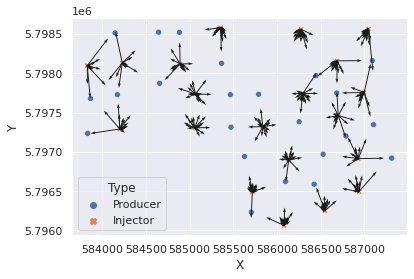

In [12]:
g = sns.scatterplot(data=locations, x="X", y="Y", style="Type", hue="Type",)
plt.quiver(homogeneous_arrows["X"], homogeneous_arrows["Y"], homogeneous_arrows["x_arrow"], homogeneous_arrows["y_arrow"])

[Text(0.5, 0, 'Summed gains'), Text(0, 0.5, 'Number of injectors')]

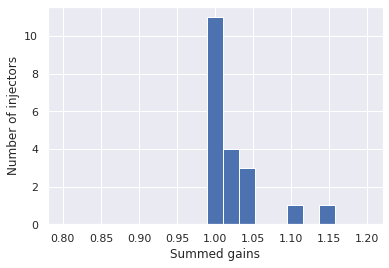

In [13]:
(
    Lambda_jax.stack()
    .pipe(lambda x: np.clip(-x, 1e-4, 1))
    .rename_axis(index=["Producer", "Injector"])
    .groupby("Injector")
    .sum()
    .rename("Summed injector gains")
).hist(bins=np.linspace(0.8,1.2,20))
plt.gca().set(xlabel='Summed gains', ylabel='Number of injectors')

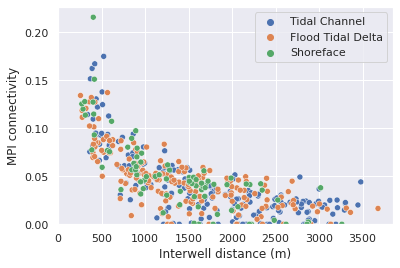

In [14]:
data = (
    Lambda_jax.stack()
    .pipe(lambda x: np.clip(-x, 1e-4, 1))
    .rename_axis(index=["Producer", "Injector"])
    .rename("Connectivity")
    .reset_index()
    .merge(distances, how="left")
)

g = sns.scatterplot(data=data, x="dist", y="Connectivity", hue="Deposition_producer")
g.set(
    xlabel="Interwell distance (m)",
    ylabel="MPI connectivity",
    xlim=(0, None),
    ylim=(0, None),
)
g.legend()

In [15]:
(data.Connectivity == data.Connectivity.min()).sum(), data.shape

(35, (460, 7))

$$\begin{align}\lambda_{guess} &\sim U(a, b)\\
a &= \max(0, \lambda_{MPI} - 0.1), \\
b &= \min(1, \lambda_{MPI} + 0.1)\end{align}$$

In [33]:
from utilities import fit_given_guess, extract_gains

{}
CPU times: user 13min 43s, sys: 2.19 s, total: 13min 45s
Wall time: 13min 49s


<AxesSubplot:>

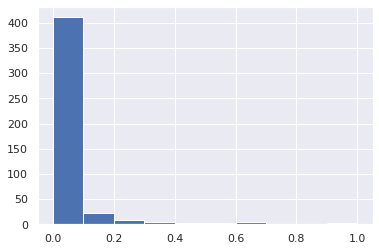

In [38]:
prod.index = pd.date_range('1999-01-31','2009-12-31', freq='M')
gains_mpi = Lambda.pipe(lambda x: np.clip(-x, 1e-4, 1)).values

%time crm_mpi = fit_given_guess(prod, inj, gains_mpi)

gains_crm_mpi = extract_gains(crm_mpi, prod.columns, inj.columns)
gains_crm_mpi['Gain'].hist()

In [46]:
os.listdir('../results/Senlac')

['monte_carlo18.csv',
 'monte_carlo8.csv',
 'monte_carlo58.csv',
 'monte_carlo86.csv',
 'monte_carlo81.csv',
 'monte_carlo43.csv',
 'monte_carlo52.csv',
 'monte_carlo7.csv',
 'monte_carlo85.csv',
 'monte_carlo22.csv',
 'monte_carlo21.csv',
 'monte_carlo64.csv',
 'monte_carlo47.csv',
 'monte_carlo31.csv',
 'monte_carlo80.csv',
 'monte_carlo24.csv',
 'monte_carlo4.csv',
 'monte_carlo63.csv',
 'monte_carlo59.csv',
 'monte_carlo46.csv',
 'monte_carlo38.csv',
 'monte_carlo90.csv',
 'monte_carlo66.csv',
 'monte_carlo41.csv',
 'monte_carlo19.csv',
 'monte_carlo26.csv',
 'monte_carlo69.csv',
 'monte_carlo48.csv',
 'monte_carlo17.csv',
 'monte_carlo20.csv',
 'monte_carlo42.csv',
 'monte_carlo50.csv',
 'monte_carlo70.csv',
 'monte_carlo60.csv',
 'monte_carlo96.csv',
 'monte_carlo1.csv',
 'monte_carlo9.csv',
 'monte_carlo34.csv',
 'monte_carlo77.csv',
 'monte_carlo89.csv',
 'monte_carlo76.csv',
 'monte_carlo40.csv',
 'monte_carlo71.csv',
 'monte_carlo25.csv',
 'monte_carlo30.csv',
 'monte_carlo14

In [54]:
gains_monte_carlo = pd.concat([
    pd.read_csv('../results/Senlac/' + x) for x in os.listdir('../results/Senlac')
]).rename(columns={'level_0':"Producer",'level_1':"Injector"}).iloc[:,1:]
gains_monte_carlo.describe()

,Gain,Tau,log_gain
count,77280.000000,7.728000e+04,7.728000e+04
mean,0.043638,6.390378e+02,-4.711265e+00
std,0.135257,9.941183e+03,2.162131e+00
min,0.000000,1.000000e-10,-6.000000e+00
25%,0.000000,7.640464e+00,-6.000000e+00
50%,0.000000,2.799380e+01,-6.000000e+00
75%,0.004862,4.120723e+01,-2.313130e+00
max,1.000000,1.221693e+06,4.342943e-07


In [59]:
gains_monte_carlo.to_csv('../results/gains_MC_Senlac.csv')

<AxesSubplot:xlabel='Gain', ylabel='Count'>

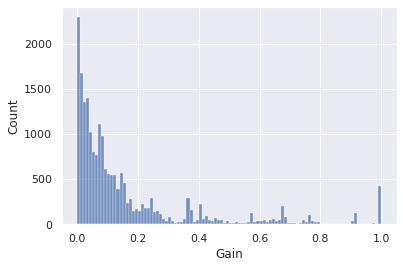

In [57]:
sns.histplot(data=gains_monte_carlo.query('Gain>0'), x='Gain', bins=100)

In [41]:

def init_fit_extract_gains_mc(prod, inj, gains, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    gains_guess = gains + rng.uniform(-0.1, 0.1, gains.shape)
    gains_guess[gains_guess<1e-4] = 1e-4
    gains_guess[gains_guess>1] = 1
    crm_mc = fit_given_guess(prod, inj, gains_guess)
    gains_mc = extract_gains(crm, prod.columns, inj.columns)
    return gains_mc

rng = np.random.default_rng(420)
gains_mc = pd.concat([init_fit_extract_gains_mc(prod, inj, gains_mpi, rng) for i in range(10)])

{}


KeyboardInterrupt: 

In [21]:
Lambda.values[0].shape, n_inj, n_prod


((20,), 20, 23)

In [24]:
for x in injection:
    print(len(x))
    break

20


In [14]:
constrainer = "up-to one"
crm_mpi = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
crm_mpi.set_rates(production, injection, time)
gains_mpi = Lambda_jax.pipe(lambda x: np.clip(-x, 1e-4, 1))
#gains_mpi.iloc[:,1:] = 0
#gains_mpi.loc["P02":,:] = 0
tau_mpi = np.full_like(gains_mpi.values, 1*30.5)
gains_producer_mpi = np.zeros(production.shape[1])
tau_producer_mpi = np.full(production.shape[1], 30.5)
#initial_guess = np.concatenate([gains_mpi, crm_mpi._get_initial_guess()[len(gains_mpi):]])
crm_mpi.set_connections(
    gains=gains_mpi.values, 
    tau=tau_mpi, 
    gains_producer=gains_producer_mpi,
    tau_producer=tau_producer_mpi,
)
pred = pd.DataFrame(crm_mpi.predict(), index=time, columns=Lambda_jax.index)

[(0.0, 60.0), Text(0.5, 0, 'Production rate (kbbl/m)')]

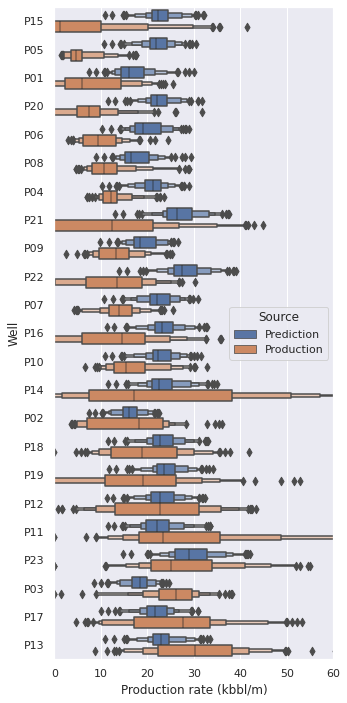

In [15]:
d = pd.concat([
    pd.DataFrame(crm_mpi.predict()/1e3, index=time, columns=Lambda_jax.index).stack().rename('rate').reset_index().assign(Source='Prediction'),
    pd.DataFrame(production/1e3, index=time, columns=Lambda_jax.index).stack().rename('rate').reset_index().assign(Source='Production')
])

fig = plt.figure(figsize=(5,12))
order = d[d.Source=='Production'].groupby('Well')['rate'].median().sort_values().index
g = sns.boxenplot(data=d, y='Well', x='rate', hue='Source', order=order)
g.set(xlim=(0,60), xlabel='Production rate (kbbl/m)')

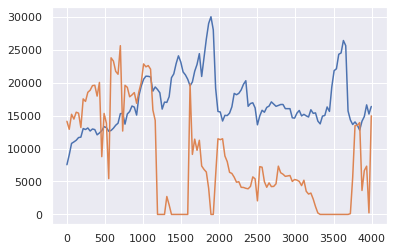

In [16]:
plt.plot(time, crm_mpi.predict()[:,0])
plt.plot(time, production[:,0])

[Text(0.5, 0, 'Time'), (0.0, 4000.0), (0.0, 767404.1527919818)]

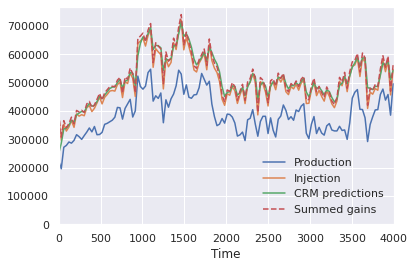

In [17]:
plt.plot(time,production.sum(1), label='Production')
plt.plot(time, injection.sum(1), label='Injection')
pred.sum(1).rename('CRM predictions').plot()
plt.plot(time, np.einsum('ki,ji->k',injection, gains_mpi), '--', label='Summed gains')
plt.legend(loc='lower right', frameon=False)
plt.gca().set(xlabel='Time', xlim=(0,4e3), ylim=(0,None))

<AxesSubplot:xlabel='Well', ylabel='Well'>

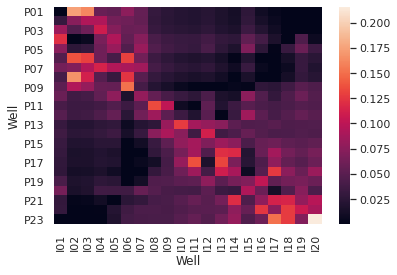

In [18]:
sns.heatmap(gains_mpi)#.reshape(production.shape[1], injection.shape[1]))
#pd.DataFrame(gains_mpi.reshape(production.shape[1], injection.shape[1])).sum(axis=0)

In [19]:
%%time 
constrainer = "sum-to-one injector"
crm_mpi = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
crm_mpi.set_rates(production, injection, time)
gains_mpi = Lambda_jax.stack().pipe(lambda x: np.clip(-x, 1e-4, 1)).values
initial_guess = np.concatenate([gains_mpi, crm_mpi._get_initial_guess()[len(gains_mpi):]])

crm_mpi.fit(
    production,
    injection,
    time,
    initial_guess=initial_guess,
    method="trust-constr",
    options={"disp": True, "maxiter": 300}
)

/home/frank/anaconda3/envs/crm/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The maximum number of function evaluations is exceeded.
Number of iterations: 300, function evaluations: 314275, CG iterations: 242336, optimality: 4.85e+07, constraint violation: 0.00e+00, execution time: 3.7e+04 s.
CPU times: user 17h 4min 19s, sys: 4h 19min 29s, total: 21h 23min 49s
Wall time: 10h 25min 50s


<AxesSubplot:>

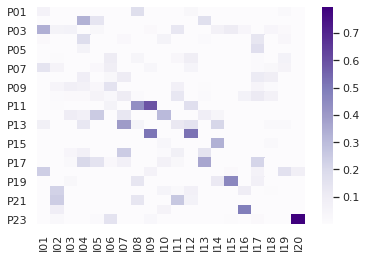

In [20]:
gains_mpi = pd.DataFrame(crm_mpi.gains, index=prod.columns, columns=inj.columns)

sns.heatmap(gains_mpi, cmap='Purples')

<AxesSubplot:>

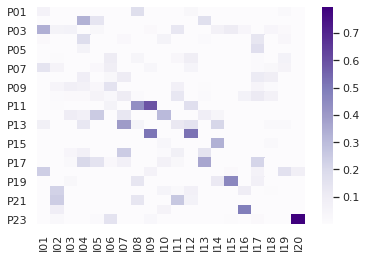

In [21]:
gains_mpi = pd.DataFrame(crm_mpi.gains, index=prod.columns, columns=inj.columns)
gains_mpi.to_csv(OUT_DIR+'Senlac_CRM_jax_gains.csv')

sns.heatmap(gains_mpi, cmap='Purples')

In [22]:
crm_arrows = arrows(
    gains_mpi.rename_axis(index='Well',columns='Well').T.stack().rename("Gain").to_frame(),
    locations,
    arrow_factor=1,
).join(locations[locations.Type == "Injector"])

In [23]:
crm_arrows.index.levels[0]

Index(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10',
       'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20'],
      dtype='object', name='Well')

In [24]:
crm_arrows.groupby(level=0).max()

,Gain,angle,dist,x_arrow,y_arrow,X,Y,Type
Well,,,,,,,,
I01,0.338843,3.124364,2564.741322,1.979185e-01,-1.512329e-10,585357.2,5798581.5,Injector
I02,0.245283,3.136496,3676.783569,2.434708e-01,2.251479e-02,583829.1,5798099.2,Injector
I03,0.100966,2.480724,3312.674462,7.688536e-02,3.376549e-02,584229.3,5798133.8,Injector
I04,0.329810,2.733602,2702.172889,1.829160e-01,2.818511e-01,584890.7,5798120.7,Injector
I05,0.250573,2.739676,2388.801099,1.445539e-01,1.258381e-01,585067.1,5797737.6,Injector
I06,0.150613,2.183299,3133.428916,1.440819e-01,1.068164e-01,584200.7,5797292.2,Injector
I07,0.397187,2.598121,2286.745145,3.516187e-01,3.240526e-02,585058.1,5797306.9,Injector
I08,0.437896,1.434682,2562.423246,8.495841e-02,1.398393e-01,585717.9,5796491.7,Injector
I09,0.591839,0.962452,3123.127287,4.064332e-02,5.152585e-01,586081.3,5796064.1,Injector


In [25]:
crm_mpi.to_pickle(OUT_DIR + 'Senlac_CRM_jax.pkl')
crm_mpi.to_excel(OUT_DIR + 'Senlac_CRM_jax.xlsx')

In [28]:
gains_mpi.sum(axis=0)

I01    0.916188
I02    0.783758
I03    0.371953
I04    1.213663
I05    0.697690
I06    0.605528
I07    1.129803
I08    0.977614
I09    1.406500
I10    0.591976
I11    0.880905
I12    1.227601
I13    0.817870
I14    0.789186
I15    0.611946
I16    0.699696
I17    0.982006
I18    0.297312
I19    0.359471
I20    0.867954
dtype: float64

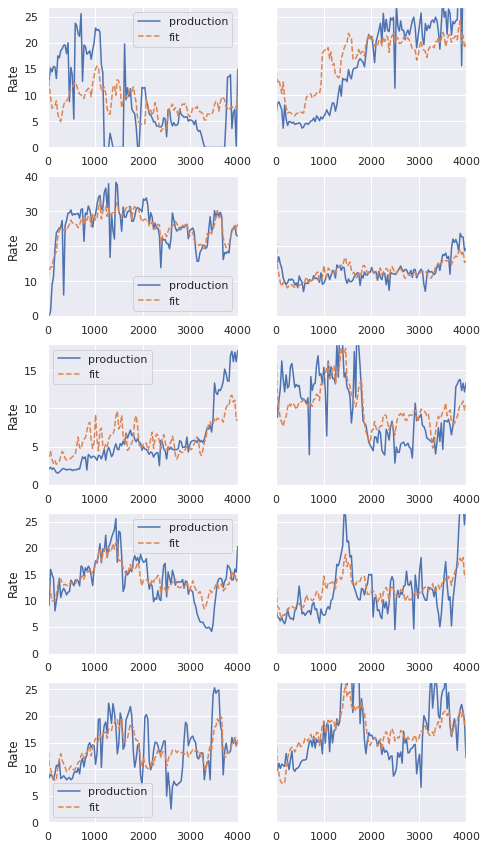

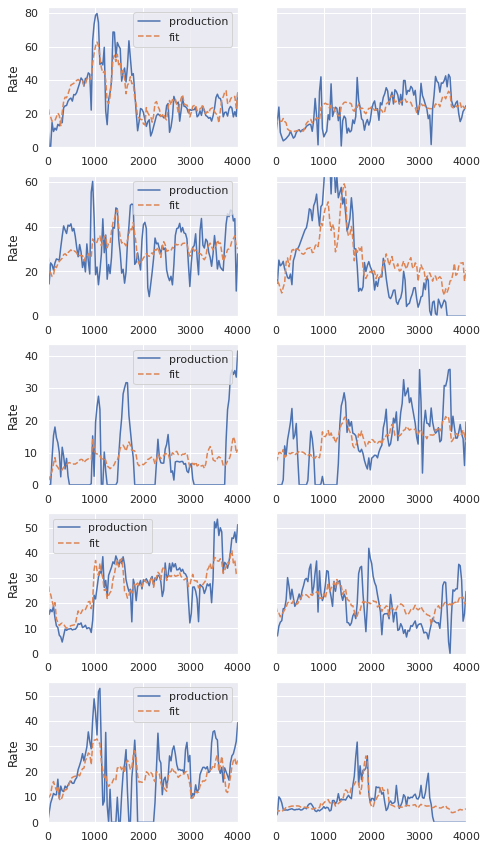

In [26]:
pred = crm_mpi.predict()

num_prods = 10
for j in range(pred.shape[1] // num_prods):
    fig, axes = plt.subplots(num_prods // 2, 2, figsize=(5*1.5,num_prods*1.5), sharey="row")
    j2 = j * num_prods
    for i in range(production.shape[1])[j2: (j + 1) * num_prods]:
        ax = axes.ravel()[i-j2]
        #plt.figure()
        ax.plot(time, production[:,i] / 1e3, '-', label='production')
        ax.plot(time, pred[:,i] / 1e3, '--', label='fit')
        ax.set(xlim=(0,4e3), ylim=(0,None))

        if i % 2 == 0:
            ax.legend()
            ax.set(ylabel='Rate')

In [36]:
Lambda_jax.pipe(lambda x: np.clip(-x, 1e-4, 1)).to_csv(OUT_DIR + 'lambda_matrix_MPI.csv')

In [44]:
%%time 
constrainer = "up-to one"
crm_mpi_loose = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
crm_mpi_loose.set_rates(production, injection, time)
gains_mpi = Lambda_jax.stack().pipe(lambda x: np.clip(-x, 1e-4, 1)).values
initial_guess = np.concatenate([gains_mpi, crm_mpi._get_initial_guess()[len(gains_mpi):]])

crm_mpi_loose.fit(
    production,
    injection,
    time,
    initial_guess=initial_guess,
    method="trust-constr",
    options={"disp": True, "maxiter": 1000}
)

The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 967000, CG iterations: 954780, optimality: 6.68e+06, constraint violation: 0.00e+00, execution time: 3.2e+03 s.
CPU times: user 1h 42min 39s, sys: 8min 2s, total: 1h 50min 41s
Wall time: 52min 55s


In [70]:
%%time 
constrainer = "up-to one"
crm_mpi_loose = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
crm_mpi_loose.set_rates(production, injection, time)
gains_mpi = Lambda_jax.stack().pipe(lambda x: np.clip(-x, 1e-4, 1)).values
initial_guess = np.concatenate([gains_mpi/20, crm_mpi._get_initial_guess()[len(gains_mpi):]])

crm_mpi_loose.fit(
    production,
    injection,
    time,
    initial_guess=initial_guess,
    method="TNC",
    options={"disp": True, "maxiter": 1000}
)

CPU times: user 43min 59s, sys: 5min 23s, total: 49min 22s
Wall time: 37min 15s


In [71]:
crm_mpi_loose.gains.sum(axis=1).round(2)

array([0.04, 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.04, 0.05, 0.05,
       0.06])

[Text(0.5, 1.0, 'Capacitance-resistance model')]

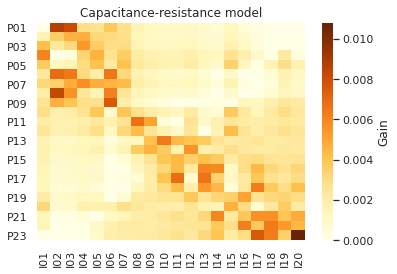

In [72]:
g = sns.heatmap(pd.DataFrame(crm_mpi_loose.gains, index=prod.columns, columns=inj.columns), vmin=0, cmap='YlOrBr', cbar_kws={'label':'Gain'})
g.set(title='Capacitance-resistance model')

<ipython-input-73-3ced72fc198d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


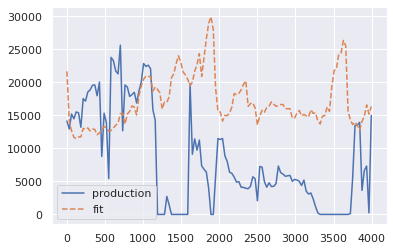

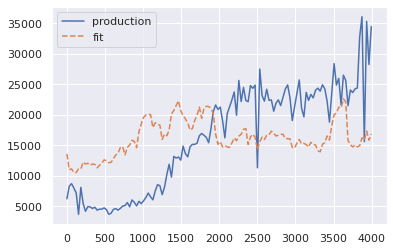

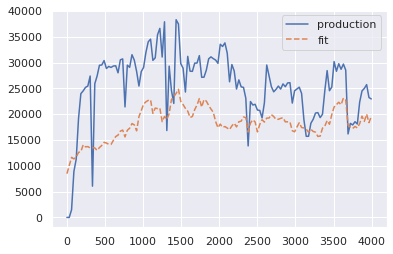

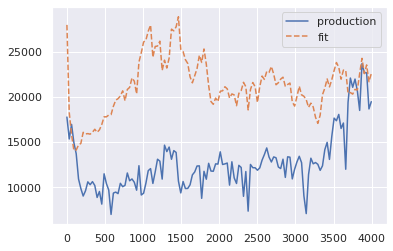

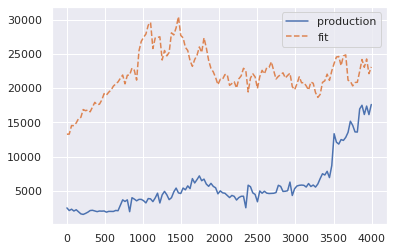

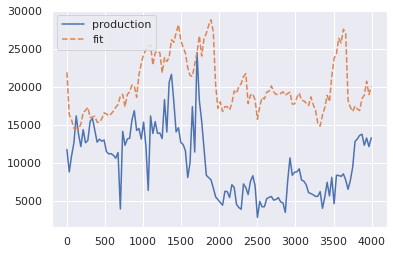

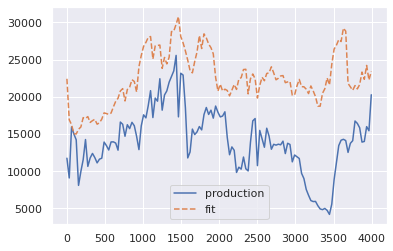

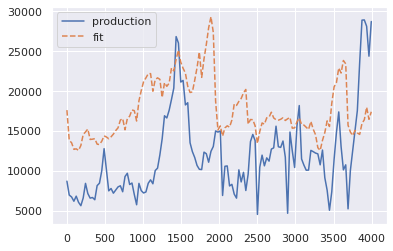

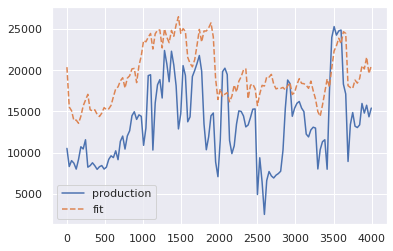

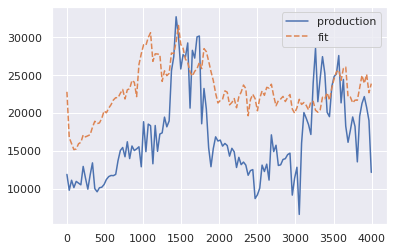

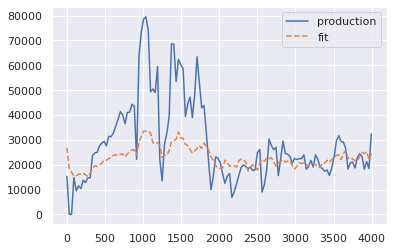

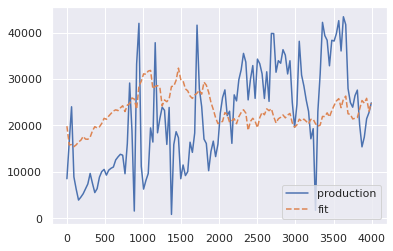

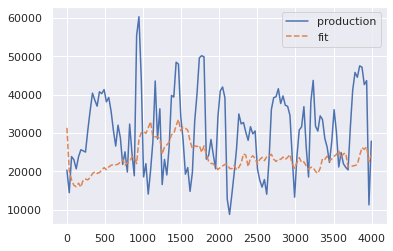

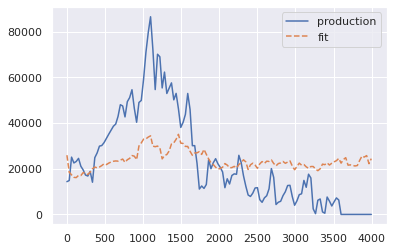

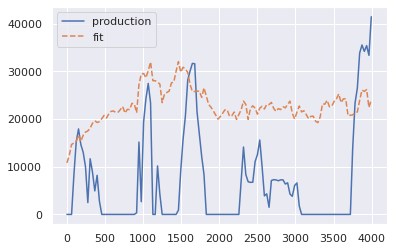

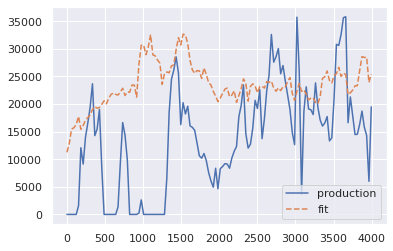

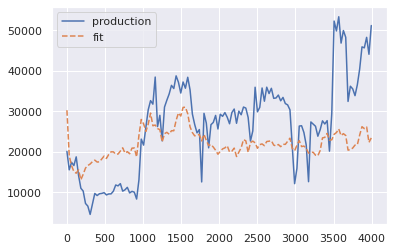

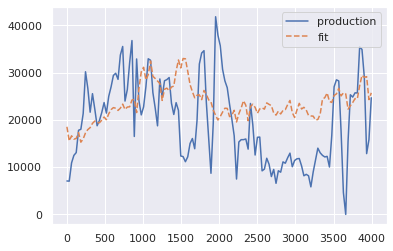

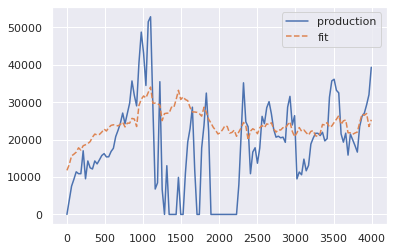

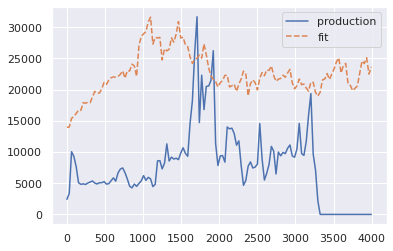

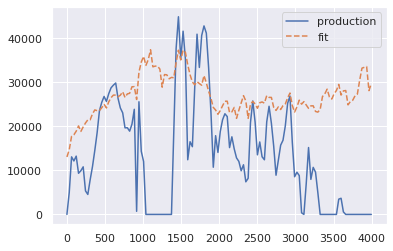

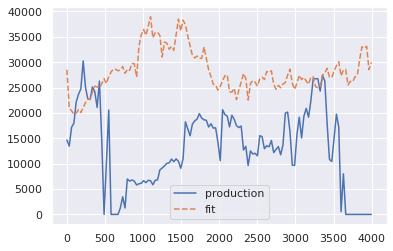

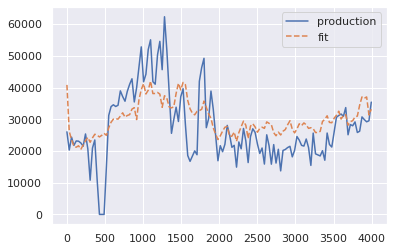

In [73]:
pred = crm_mpi_loose.predict()
for i in range(production.shape[1]):
    plt.figure()
    plt.plot(time, production[:,i], '-', label='production')
    plt.plot(time, pred[:,i], '--', label='fit')
    plt.legend()

# Multi-precision math library

In [111]:
from mpmath import mp

In [133]:
from scipy import linalg

In [252]:
mp.dps = 30


def calc_A_ij_tight(x_i, y_i, x_j, y_j, y_D, m_max=500):
    "Calculate A_ij using arbitrary-accuracy math package"
    x_i, y_i, x_j, y_j = (
        max([x_i, x_j]),
        max([y_i, y_j]),
        min([x_i, x_j]),
        min([y_i, y_j]),
    )
    y_D = y_D if x_i - x_j > y_i - y_j else 1 / y_D

    def calc_tm(m, y_D, y_i, y_j):
        tm = (
            mp.cosh(m * mp.pi * (y_D - abs(y_i - y_j)))
            + mp.cosh(m * mp.pi * (y_D - y_i - y_j))
        ) / mp.sinh(m * mp.pi * y_D)
        return tm

    first_term = (
        2 * mp.pi * y_D * (1 / 3.0 - y_i / y_D + (y_i ** 2 + y_j ** 2) / (2 * y_D ** 2))
    )
    M = 1 + np.arange(m_max)
    second_term = sum(
        [
            calc_tm(m, y_D, y_i, y_j)
            / m
            * mp.cos(m * mp.pi * x_i)
            * mp.cos(m * mp.pi * x_j)
            for m in M
        ]
    )
    return float(first_term + 2 * second_term)


# should be 10.6867
#%time calc_A_ij_tight(0.233351184, 0.36666667, 0.23333333, 0.36666667, 0.5, m_max=100_000)

# build influence matrices
idx = pd.IndexSlice


def calc_influence_matrix(locations, y_D, matrix_type="conn", m_max=10_000):
    assert matrix_type in ["conn", "prod"]
    XA = locations[locations.Type == "Producer"]
    if matrix_type == "prod":
        XB = XA.copy()
    else:
        XB = locations[locations.Type == "Injector"]
    influence_matrix = pd.DataFrame(
        index=pd.MultiIndex.from_product([XA.index, XB.index]), columns=["A"]
    )
    for i, j in influence_matrix.index:
        x_i, y_i = XA.loc[i, ["X", "Y"]]
        x_j, y_j = XB.loc[j, ["X", "Y"]] + 1e-6
        influence_matrix.loc[idx[i, j], "A"] = calc_A_ij_tight(
            x_i, y_i, x_j, y_j, y_D, m_max
        )
    return influence_matrix["A"].unstack(level=0)


def calc_gains_homogeneous(locations, x_e, y_e, m_max=1_000):
    locations = locations.copy()
    locations[["X", "Y"]] /= x_e
    y_D = y_e / x_e
    A_prod = calc_influence_matrix(locations, y_D, "prod", m_max).astype(float)
    A_conn = calc_influence_matrix(locations, y_D, "conn", m_max).astype(float)
    A_prod_inv = linalg.inv(A_prod.values)
    term1 = A_prod_inv / np.sum(A_prod_inv)
    term2 = np.ones((N_producers, N_producers)) @ A_prod_inv @ A_conn.values.T - 1
    term3 = A_prod_inv @ A_conn.values.T
    Lambda = term1 @ term2 - term3
    return pd.DataFrame(Lambda, index=A_prod.index, columns=A_conn.index)

In [228]:
%time Lambda = calc_gains_homogeneous(locations_translated, x_e, y_e, 2_000)

CPU times: user 5min 35s, sys: 317 ms, total: 5min 35s
Wall time: 5min 36s


In [206]:
locations_scaled = locations_translated.assign(
    X=locations_translated.X / x_e, Y=locations_translated.Y / x_e
)
y_D = y_e / x_e
%time A_prod = calc_influence_matrix(locations_scaled, y_D, "prod", m_max=1000).astype(float)
%time A_conn = calc_influence_matrix(locations_scaled, y_D, "conn", m_max=1000).astype(float)

CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 28s
CPU times: user 1min 17s, sys: 71.7 ms, total: 1min 17s
Wall time: 1min 17s


In [216]:
A_prod_inv = linalg.inv(A_prod.astype(float).values)

term1 = 1 / np.sum(A_prod_inv) * A_prod_inv
term2 = np.dot(np.dot(np.ones_like(A_prod_inv), A_prod_inv), A_conn.T) - 1
term3 = np.dot(A_prod_inv, A_conn.T)

Lambda_x = np.dot(term1, term2) - term3

<AxesSubplot:xlabel='Well'>

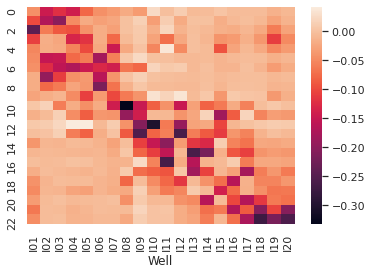

In [251]:
A_prod_inv = linalg.inv(A_prod.astype(float).values)

term1 = 1 / np.sum(A_prod_inv) * A_prod_inv
term2 = np.ones_like(A_prod_inv) @ A_prod_inv @ A_conn.T - 1
term3 = A_prod_inv @ A_conn.T

Lambda_x = term1 @ term2 - term3
sns.heatmap(Lambda_x)

<AxesSubplot:xlabel='Well', ylabel='Well'>

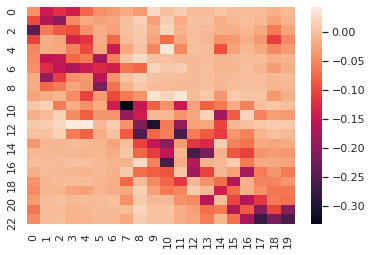

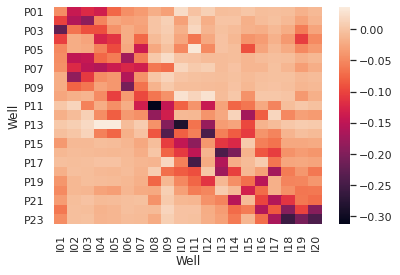

In [229]:
sns.heatmap(Lambda_x)
plt.figure()
sns.heatmap(Lambda)

In [250]:
Lambda.to_csv("../results/lambda_matrix_MPI.csv")

<AxesSubplot:xlabel='Well', ylabel='Well'>

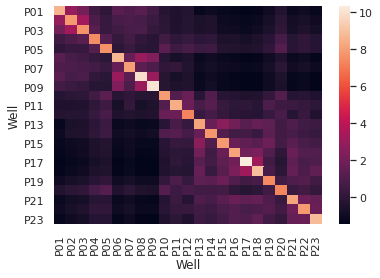

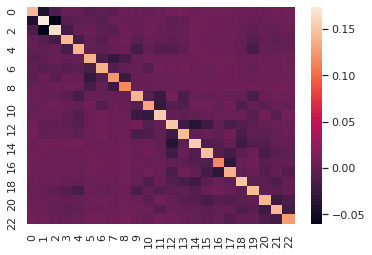

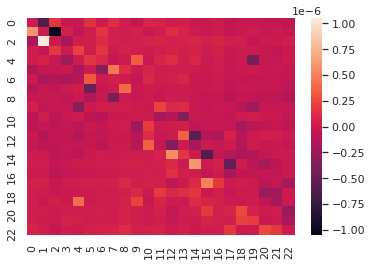

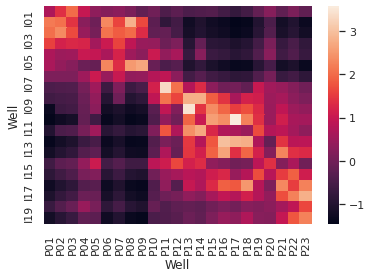

In [245]:
plt.figure()
sns.heatmap(A_prod)

plt.figure()
sns.heatmap(A_prod_inv)

plt.figure()
sns.heatmap(A_prod_inv - A_prod_inv.T)


plt.figure()
sns.heatmap(A_conn.astype(float))

In [167]:
sum(sum(A_prod_inv))

2.323117126846524

In [154]:
Lambda.columns = Lambda.columns.get_level_values("Well")

<AxesSubplot:xlabel='Well', ylabel='Well'>

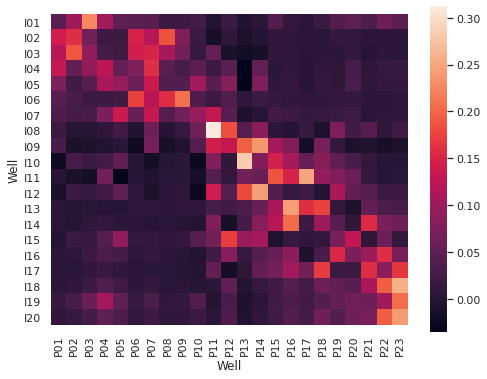

In [237]:
plt.figure(figsize=(8, 6))
sns.heatmap(-Lambda.T, square=True)

In [255]:
%time calc_A_ij_tight(0.233351184, 0.36666667, 0.23333333, 0.36666667, 0.5, m_max=100_000)

CPU times: user 15.6 s, sys: 59.6 ms, total: 15.7 s
Wall time: 15.7 s


10.560330994618786

In [141]:
print(f"{1 -10.6867/10.67957:.2%} error")

-0.07% error


In [256]:
loc_vdb = pd.DataFrame(
    {"X": [3267.0, 10266.0], "Y": [5133.0, 5133.001], "Type": ["Producer", "Producer"]}
)
A_prod = calc_A_prod(loc_vdb, 14e3, 7e3, 100_000)
A_prod_inv = pd.DataFrame(
    data=jsl.inv(A_prod.values), index=A_prod.index, columns=A_prod.columns
)

# plt.figure(figsize=(6,5))
# cmap = sns.color_palette("icefire", as_cmap=True)
# sns.heatmap(A_prod_inv, cmap=cmap, vmin=-0.05, vmax=0.05, square=True)

loc_vdb
color_negative_red = lambda x: f'color: {"red" if x <0 else "black"}'

print(A_prod)
A_prod.style.applymap(color_negative_red).format("{:.4}")
A_prod_inv.style.applymap(color_negative_red).format("{:.4}")  #

           0          1
0  12.677971  -1.263024
1  -1.263033  12.452058


,0,1
0,0.07968,0.008082
1,0.008082,0.08113


# JAX

In [234]:
# build influence matrices
idx = pd.IndexSlice


@jit
def calc_tm(m, y_D, y_i, y_j):
    tm = (
        jnp.cosh(m * jnp.pi * (y_D - jnp.abs(y_i - y_j)))
        + jnp.cosh(m * jnp.pi * (y_D - y_i - y_j))
    ) / jnp.sinh(m * jnp.pi * y_D)
    return tm


@jit
def calc_summed_term(x_i, y_i, x_j, y_j, y_D, m):
    "Calculate summed term using Valkó 2000 equations A4-7"
    S1 = 2 * jnp.sum(
        calc_tm(m, y_D, y_i, y_j)
        / m
        * jnp.cos(m * jnp.pi * x_i)
        * jnp.cos(m * jnp.pi * x_j)
    )
    tN = calc_tm(m[-1], y_D, y_i, y_j)
    S2 = -tN / 2 * jnp.log(
        (1 - jnp.cos(jnp.pi * (x_i + x_j))) ** 2 + jnp.sin(jnp.pi * (x_i + x_j)) ** 2
    ) - tN / 2 * jnp.log(
        (1 - jnp.cos(jnp.pi * (x_i - x_j))) ** 2 + jnp.sin(jnp.pi * (x_i - x_j)) ** 2
    )
    S3 = (
        -2 * tN * jnp.sum(1 / m * jnp.cos(m * jnp.pi * x_i) * jnp.cos(m * jnp.pi * x_j))
    )
    # breakpoint()
    return S1 + S2 + S3


@jit
def calc_A_ij(x_i, y_i, x_j, y_j, y_D, m):
    first_term = (
        2
        * jnp.pi
        * y_D
        * (1 / 3.0 - y_i / y_D + (y_i ** 2 + y_j ** 2) / (2 * y_D ** 2))
    )
    return first_term + calc_summed_term(x_i, y_i, x_j, y_j, y_D, m)


def calc_influence_matrix(locations, y_D, matrix_type="conn", m_max=300):
    assert matrix_type in ["conn", "prod"]
    XA = locations[locations.Type == "Producer"]
    if matrix_type == "prod":
        XB = XA.copy()
    else:
        XB = locations[locations.Type == "Injector"]
    influence_matrix = pd.DataFrame(
        index=pd.MultiIndex.from_product([XA.index, XB.index]), columns=["A"]
    )
    m = 1 + jnp.arange(m_max)
    for i, j in influence_matrix.index:
        x_i, y_i = XA.loc[i, ["X", "Y"]]
        x_j, y_j = XB.loc[j, ["X", "Y"]] + 1e-6
        influence_matrix.loc[idx[i, j], "A"] = calc_A_ij(x_i, y_i, x_j, y_j, y_D, m)
    return influence_matrix["A"].unstack()


def calc_gains_homogeneous(locations, x_e, y_e):
    locations = locations.copy()
    locations[["X", "Y"]] /= x_e
    y_D = y_e / x_e
    A_prod = calc_influence_matrix(locations, y_D, "prod").astype(float)
    A_conn = calc_influence_matrix(locations, y_D, "conn").astype(float)
    A_prod_inv = jsl.inv(A_prod.values)
    term1 = A_prod_inv / jnp.sum(A_prod_inv)
    term2 = (
        jnp.einsum(
            "kj,jp,pi->ki",  # three dot products in a row
            jnp.ones((N_producers, N_producers)),
            A_prod_inv,
            A_conn.values,
        )
        - 1
    )
    term3 = jnp.dot(A_prod_inv, A_conn.values)
    Lambda = jnp.dot(term1, term2) - term3
    return pd.DataFrame(Lambda, index=A_prod.index, columns=A_conn.columns)

In [235]:
locations_translated = locations.assign(
    X=lambda x: x.X + 100 - x.X.min(), Y=lambda x: x.Y + 100 - x.Y.min()
)
x_e, y_e = locations_translated[["X", "Y"]].max() + 100

%time Lambda_jax = calc_gains_homogeneous(locations_translated, x_e, y_e) # compile time included
%timeit calc_gains_homogeneous(locations_translated, x_e, y_e)

CPU times: user 1.81 s, sys: 20.7 ms, total: 1.83 s
Wall time: 1.65 s
1.51 s ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<AxesSubplot:xlabel='Well', ylabel='Well'>

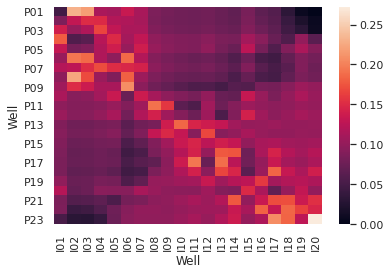

In [243]:
sns.heatmap(Lambda_jax.max().max() - Lambda_jax)

In [99]:
def annotate_well_locs(ax, locations):
    for i in range(locations.shape[0]):
        ax.annotate(
            locations.index[i], (locations["X"].iloc[i], locations["Y"].iloc[i]),
        )
    return ax

<AxesSubplot:xlabel='X', ylabel='Y'>

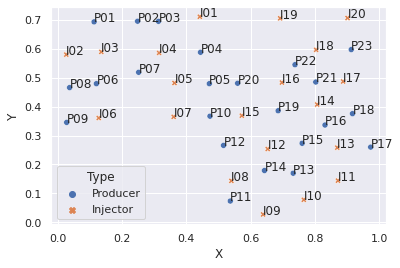

In [106]:
data = locations_translated.assign(
    X=locations_translated.X / x_e, Y=locations_translated.Y / x_e
)
ax = sns.scatterplot(data=data, x="X", y="Y", style="Type", hue="Type")
# ax = data.plot.scatter(x="X", y="Y")
annotate_well_locs(ax, data)

[Text(0.5, 30.5, 'Injector'), Text(175.64260869565226, 0.5, 'Producer')]

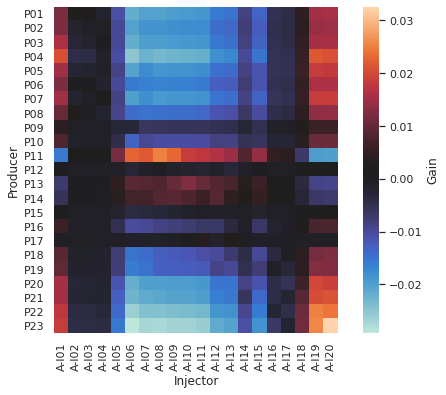

In [109]:
plt.figure(figsize=(9, 6))
g = sns.heatmap(
    Lambda,
    cmap="icefire",
    square=True,
    annot=False,
    fmt=".1f",
    cbar_kws={"label": "Gain"},
)
g.set(xlabel="Injector", ylabel="Producer")

<AxesSubplot:xlabel='None-Well', ylabel='Well'>

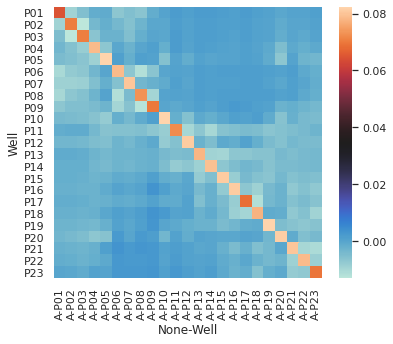

In [87]:
x_e = 3583
y_e = 2600
locations_scaled = locations.assign(
    X=lambda x: x.X + 100 - x.X.min(), Y=lambda x: x.Y + 100 - x.Y.min()
)
x_e, y_e = locations_scaled[["X", "Y"]].max() + 100
A_prod = calc_A_prod(locations_scaled, x_e, y_e, 10)
A_prod_inv = pd.DataFrame(
    data=jsl.inv(A_prod.values), index=A_prod.index, columns=A_prod.columns
)

plt.figure(figsize=(6, 5))
cmap = sns.color_palette("icefire", as_cmap=True)
sns.heatmap(
    A_prod_inv, cmap=cmap,
)  # vmin=-0.05, vmax=0.05, square=True)

In [61]:
loc_vdb = pd.DataFrame(
    {"X": [3267.0, 10266.0], "Y": [5133.0, 5133.001], "Type": ["Producer", "Producer"]}
)
A_prod = calc_A_prod(loc_vdb, 14e3, 7e3, 100)
A_prod_inv = pd.DataFrame(
    data=jsl.inv(A_prod.values), index=A_prod.index, columns=A_prod.columns
)

# plt.figure(figsize=(6,5))
# cmap = sns.color_palette("icefire", as_cmap=True)
# sns.heatmap(A_prod_inv, cmap=cmap, vmin=-0.05, vmax=0.05, square=True)

loc_vdb
color_negative_red = lambda x: f'color: {"red" if x <0 else "black"}'

A_prod.style.applymap(color_negative_red).format("{:.4}")
A_prod_inv.style.applymap(color_negative_red).format("{:.4}")  #

<AxesSubplot:>

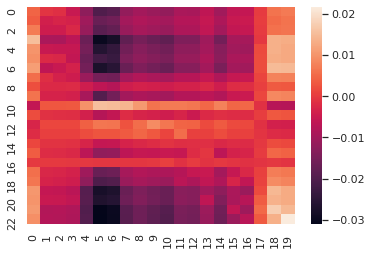

In [149]:
sns.heatmap(Lambda)

<AxesSubplot:xlabel='None-Well', ylabel='Well'>

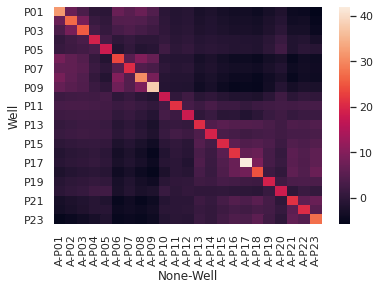

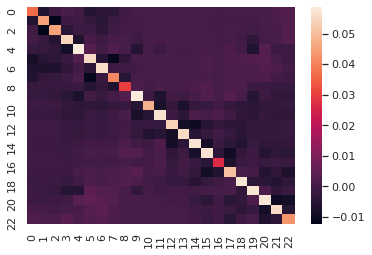

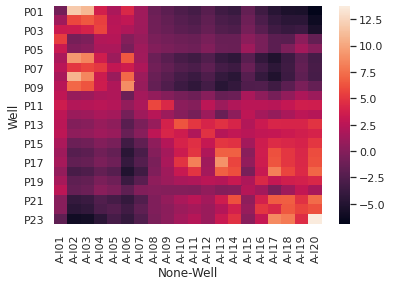

In [140]:
sns.heatmap(A_prod)
plt.figure()
sns.heatmap(A_prod_inv)
plt.figure()
sns.heatmap(A_conn)

In [ ]:
# Concern: shouldn't A_conn need to be transposed?
# A_prod is symmetric (see above) as one would hope

In [183]:
idx = pd.IndexSlice


def injector_producer_unitarrows(locations, injectors, producers):
    out = pd.DataFrame(
        index=pd.MultiIndex.from_product([injectors, producers]),
        columns=["angle", "xn", "yn"],
    )
    for (i, p) in out.index:
        x1, y1 = locations.loc[i, ["X", "Y"]]
        x2, y2 = locations.loc[p, ["X", "Y"]]
        out.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
    out["xn"] = out["angle"].map(np.sin)
    out["yn"] = out["angle"].map(np.cos)
    return out


def arrows(gains_spatial, locations, arrow_factor=1):
    to_join = pd.DataFrame(
        index=gains_spatial.index.drop_duplicates(),
        columns=["angle", "dist", "xn", "yn"],
        dtype="float",
    )
    for (i, p) in to_join.index:
        x1, y1 = locations.loc[i, ["X", "Y"]]
        x2, y2 = locations.loc[p, ["X", "Y"]]
        to_join.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
        to_join.loc[idx[i, p], "dist"] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    to_join["xn"] = to_join["angle"].map(np.sin)
    to_join["yn"] = to_join["angle"].map(np.cos)
    new_gains_df = gains_spatial.join(to_join)
    for axis in ["x", "y"]:
        new_gains_df[axis + "_arrow"] = (
            new_gains_df[axis + "n"] * new_gains_df["Gain"] * arrow_factor
        )
    return new_gains_df.drop(columns=["xn", "yn"])


def angle(x1, x2, y1, y2):
    x_diff = x2 - x1
    y_diff = y2 - y1
    return np.arctan2(x_diff, y_diff)


homogeneous_arrows = arrows(
    Lambda.stack().rename(columns={"A": "Gain"}) - Lambda.min().min(),
    locations,
    arrow_factor=1,
).join(locations[locations.Type == "Producer"])

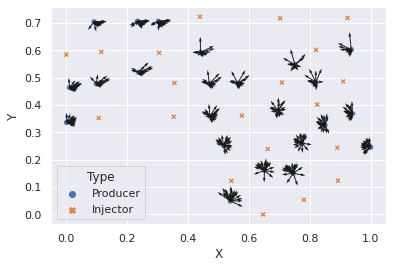

In [184]:
data = homogeneous_arrows
g = sns.scatterplot(data=locations, x="X", y="Y", style="Type", hue="Type",)
plt.quiver(data["X"], data["Y"], data["x_arrow"], data["y_arrow"])

In [134]:
A_conn.shape

(23, 20)

<AxesSubplot:>

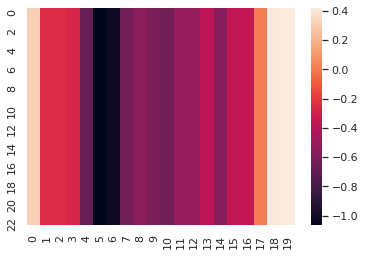

In [135]:
sns.heatmap(term2)

In [27]:
from jax.config import config

config.update("jax_enable_x64", True)  # Handy for calculating things like long series

Langevin:
$$P(\xi) = \frac1{\sqrt{2 pi \langle\Xi^2\rangle /N}} \exp\left(-N \xi^2 / 2\langle\Xi^2\rangle\right) $$

In [44]:
Xi, Xj = locations.iloc[0], locations.iloc[1]
calc_A_ij(Xi["X"], Xi["Y"], Xj["X"], Xj["Y"], y_D)

Buffer(1.98781533, dtype=float64)

In [37]:
m = jnp.arange(300) + 1

calc_tm(m, y_D, locations["Y"][0], locations["Y"][1]) / m

DeviceArray([1.93130845e+00, 8.93775504e-01, 5.65302302e-01,
             4.03373914e-01, 3.07792313e-01, 2.45247396e-01,
             2.01476227e-01, 1.69356861e-01, 1.44940238e-01,
             1.25863032e-01, 1.10626282e-01, 9.82347619e-02,
             8.80028491e-02, 7.94436198e-02, 7.22023449e-02,
             6.60149494e-02, 6.06811556e-02, 5.60465981e-02,
             5.19906030e-02, 4.84176461e-02, 4.52512650e-02,
             4.24296397e-02, 3.99023363e-02, 3.76278713e-02,
             3.55718668e-02, 3.37056373e-02, 3.20050950e-02,
             3.04498938e-02, 2.90227538e-02, 2.77089244e-02,
             2.64957531e-02, 2.53723387e-02, 2.43292479e-02,
             2.33582856e-02, 2.24523043e-02, 2.16050475e-02,
             2.08110197e-02, 2.00653774e-02, 1.93638384e-02,
             1.87026046e-02, 1.80782977e-02, 1.74879040e-02,
             1.69287278e-02, 1.63983512e-02, 1.58946002e-02,
             1.54155150e-02, 1.49593246e-02, 1.45244252e-02,
             1.41093610e

In [16]:
jnp.sinh?

Signature: jnp.sinh(x)
Docstring:
Hyperbolic sine, element-wise.

LAX-backend implementation of :func:`sinh`.

*Original docstring below.*

Equivalent to ``1/2 * (np.exp(x) - np.exp(-x))`` or
``-1j * np.sin(1j*x)``.

Parameters
----------
x : array_like
    Input array.

Returns
-------
y : ndarray
    The corresponding hyperbolic sine values.
    This is a scalar if `x` is a scalar.

References
----------
M. Abramowitz and I. A. Stegun, Handbook of Mathematical Functions.
New York, NY: Dover, 1972, pg. 83.
File:      ~/anaconda3/envs/bayes/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py
Type:      function


In [14]:
%%time

crm_kphi.fit(
    production, injection, time, global_fit=True, options={"disp": True, "maxiter": 300}
)

Splitting first generation


RecursionError: maximum recursion depth exceeded while calling a Python object

In [7]:
crm.results["fun"], crm.results["nfev"]

(160653712244.71616, 15472)

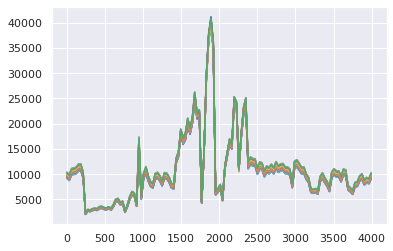

In [32]:
plt.plot(time, np.einsum("ti,pi->tp", injection, crm.gains))

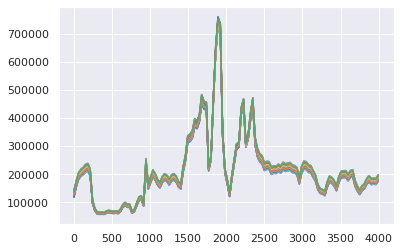

In [26]:
plt.plot(time, crm.predict())

<ipython-input-24-921cfc75a011>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


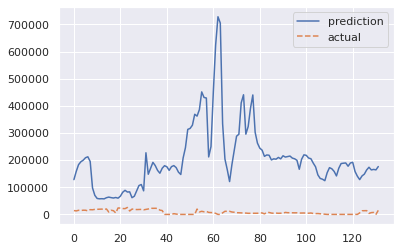

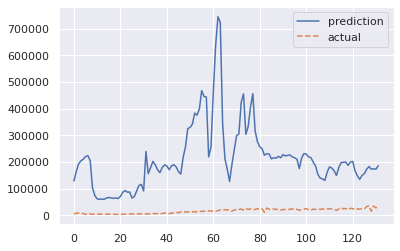

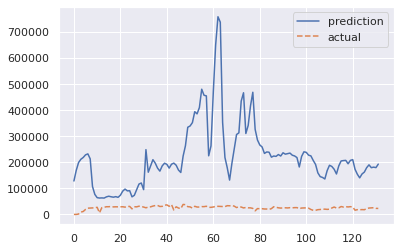

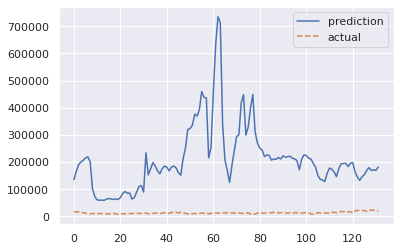

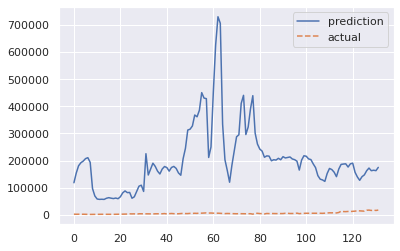

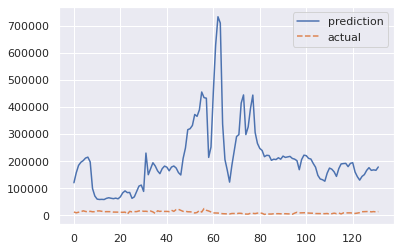

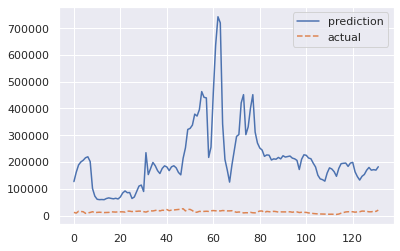

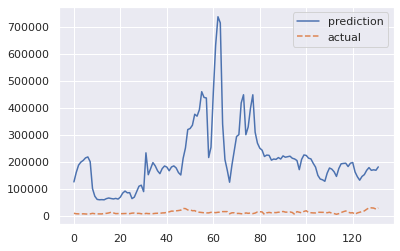

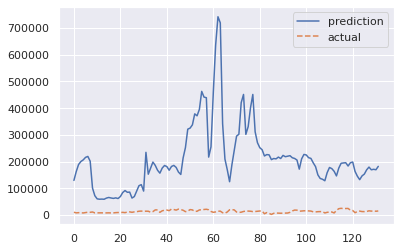

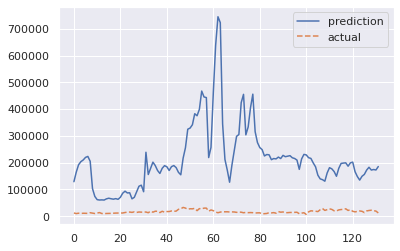

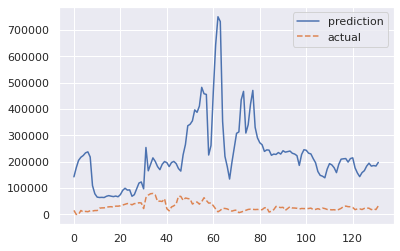

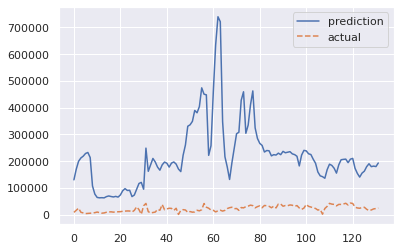

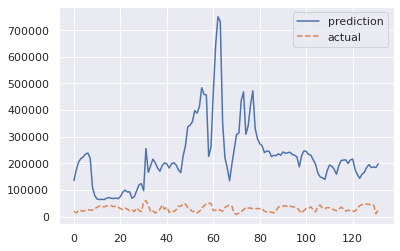

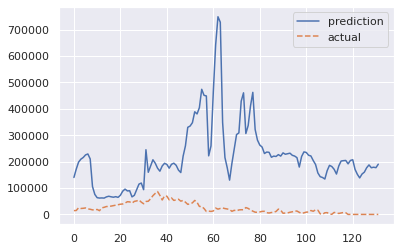

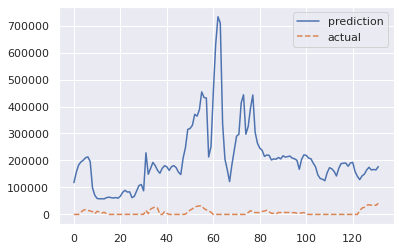

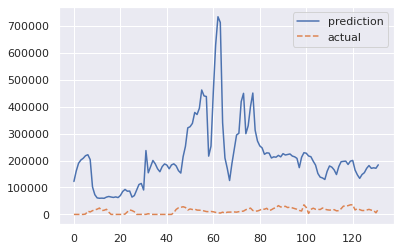

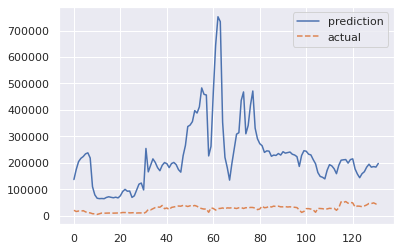

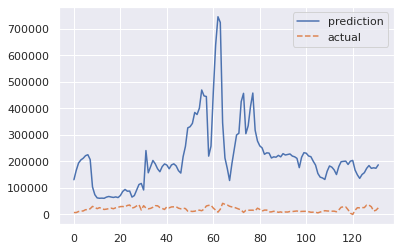

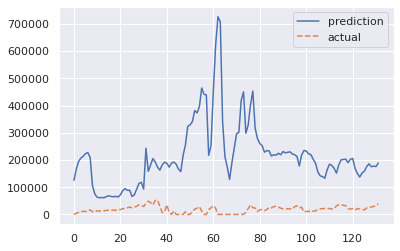

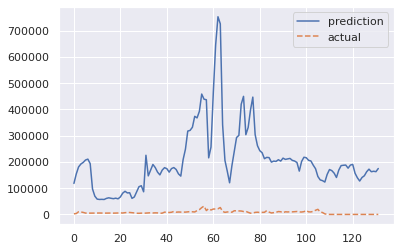

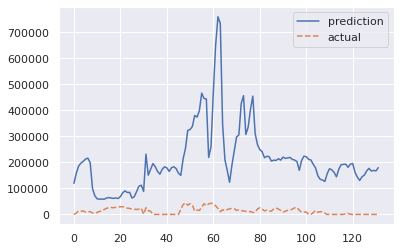

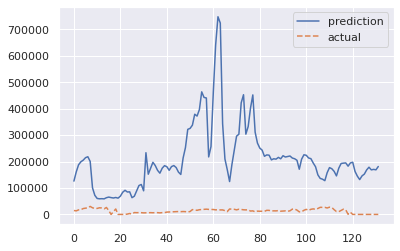

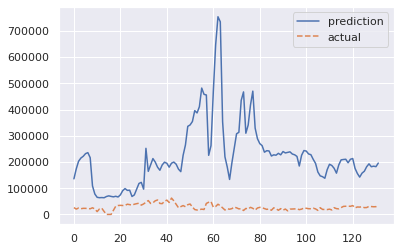

In [24]:
q_hat = crm.predict()

for i in range(q_hat.shape[1]):
    plt.figure()
    plt.plot(q_hat[:, i], label="prediction")
    plt.plot(production[:, i], "--", label="actual")
    plt.legend(loc="best")

In [33]:
%%time
constrainer = "up-to one"  # 'sum-to-one injector'


def init_and_fit(i):
    print(i)
    crm = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
    crm.fit(
        production,
        injection,
        time,
        method="trust-constr",
        options={"disp": True, "maxiter": 3000},
        random=True,
    )
    # crm.fit(production, injection, time, random=True)
    return crm


crms = [init_and_fit(i) for i in range(10)]

# crms = Parallel(n_jobs=8)(delayed(init_and_fit)(i) for i in range(8))

0


/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 530, function evaluations: 772633, CG iterations: 254444, optimality: 1.96e+07, constraint violation: 0.00e+00, execution time: 1.5e+03 s.
1
`xtol` termination condition is satisfied.
Number of iterations: 524, function evaluations: 742656, CG iterations: 275103, optimality: 1.87e+07, constraint violation: 0.00e+00, execution time: 1.5e+03 s.
2
`xtol` termination condition is satisfied.
Number of iterations: 623, function evaluations: 881904, CG iterations: 314265, optimality: 1.51e+07, constraint violation: 0.00e+00, execution time: 1.7e+03 s.
3
`xtol` termination condition is satisfied.
Number of iterations: 580, function evaluations: 758128, CG iterations: 367280, optimality: 1.05e+07, constraint violation: 0.00e+00, execution time: 1.7e+03 s.
4
`xtol` termination condition is satisfied.
Number of iterations: 521, function evaluations: 739755, CG iterations: 266969, optimality: 1.17e+07, constraint violation: 0.00e+00,

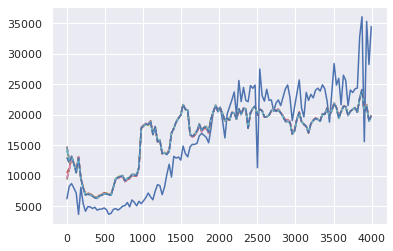

In [35]:
plt.figure()
plt.plot(time, production[:, 1])
for crm in crms:
    q_hat = crm.predict()
    plt.plot(time, q_hat[:, 1], "--")

In [45]:
def extract_gains(crm, prod, inj):
    gains = pd.DataFrame(
        columns=inj.columns.rename("injector"),
        index=prod.columns.rename("producer"),
        data=crm.gains,
    )
    taus = pd.DataFrame(
        columns=inj.columns.rename("injector"),
        index=prod.columns.rename("producer"),
        data=crm.tau,
    )
    well_pairs = (
        pd.concat([gains.stack().rename("Gain"), taus.stack().rename("Tau")], axis=1)
        .reset_index()
        .assign(log_gain=lambda x: np.log10(x.Gain))
    )
    return well_pairs


def extract_primary(crm: CRM, producers: pd.Index):
    primary_fits = pd.DataFrame(
        {"Gain primary": crm.gains_producer, "Tau primary": crm.tau_producer}, producers
    )
    return primary_fits


gains_sample = pd.concat(
    {i: extract_gains(crm, prod, inj) for i, crm in enumerate(crms)}
)
primary_sample = pd.concat(
    {
        i: extract_primary(crm, prod.columns.rename("producer"),)
        for i, crm in enumerate(crms)
    }
)

gains_sample.to_csv("results/trust_constr_gain_tau.csv")
with pd.HDFStore("results/trust_constr.h5") as store:
    store["connections"] = gains_sample
    store["primary"] = primary_sample

In [50]:
%%time
constrainer = "up-to one"  # 'sum-to-one injector'


def init_and_fit(i):
    print(i)
    crm = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
    crm.fit(
        production,
        injection,
        time,
        method="Powell",
        options={"disp": True, "maxiter": 3000},
        random=True,
    )
    # crm.fit(production, injection, time, random=True)
    return crm


crms = [init_and_fit(i) for i in range(10)]
gains_sample = pd.concat(
    {i: extract_gains(crm, prod, inj) for i, crm in enumerate(crms)}
)
primary_sample = pd.concat(
    {
        i: extract_primary(crm, prod.columns.rename("producer"),)
        for i, crm in enumerate(crms)
    }
)

gains_sample.to_csv("results/Powell_gain_tau.csv")
with pd.HDFStore("results/Powell.h5") as store:
    store["connections"] = gains_sample
    store["primary"] = primary_sample

0
Optimization terminated successfully.
         Current function value: 199312064512.000000
         Iterations: 4
         Function evaluations: 141001
1
Optimization terminated successfully.
         Current function value: 199202701312.000000
         Iterations: 4
         Function evaluations: 142277
2
Optimization terminated successfully.
         Current function value: 203158716416.000000
         Iterations: 4
         Function evaluations: 141508
3
Optimization terminated successfully.
         Current function value: 201850322944.000000
         Iterations: 4
         Function evaluations: 144139
4
Optimization terminated successfully.
         Current function value: 204381716480.000000
         Iterations: 4
         Function evaluations: 147072
5
Optimization terminated successfully.
         Current function value: 199070220288.000000
         Iterations: 4
         Function evaluations: 141317
6
Optimization terminated successfully.
         Current function value: 199

In [81]:
hours = 671 + 2 + 1 + 1 + 1 + 1 + 1 + 1 + 2 + 4 + 1 + 2 + 4 + 1 + 1  # - 631.5
months = hours / 173.33
print(hours, months)

694 4.003923152368315


[(0.0, 25.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Production or Injection rate, bbl/d')]

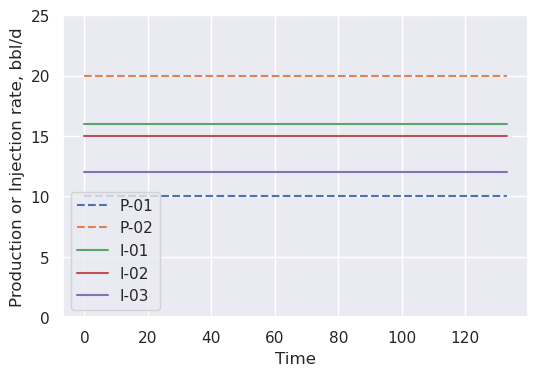

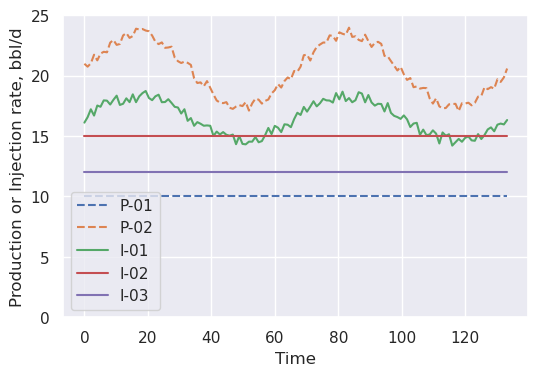

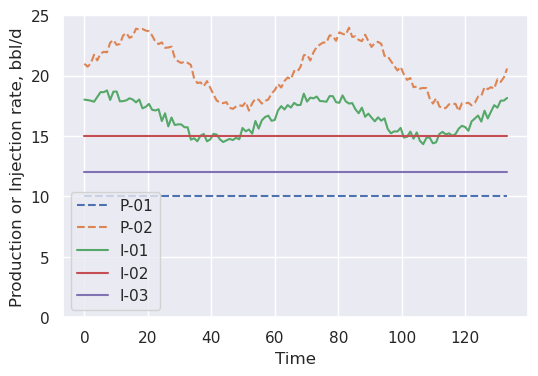

In [117]:
fig, ax = plt.subplots(dpi=100)
default_rate = np.ones_like(time) * 20
plt.plot(time / 30, default_rate * 0.5, "--", label="P-01")
plt.plot(time / 30, default_rate * 1, "--", label="P-02")
plt.plot(time / 30, default_rate * 0.8, label="I-01")
plt.plot(time / 30, default_rate * 0.75, label="I-02")
plt.plot(time / 30, default_rate * 0.6, label="I-03")
ax.legend()
ax.set(ylim=(0, 25), xlabel="Time", ylabel="Production or Injection rate, bbl/d")

variance1 = 3 * np.sin(time * np.pi / 1000) + np.random.rand(len(time))
variance2 = 1.8 * np.sin(time * np.pi / 1000) + np.random.rand(len(time))
variance3 = 1.8 * np.sin(time * np.pi / 1000 + np.pi / 4) + np.random.rand(len(time))
fig, ax = plt.subplots(dpi=100)
plt.plot(time / 30, default_rate * 0.5, "--", label="P-01")
plt.plot(time / 30, default_rate * 1 + variance1, "--", label="P-02")
plt.plot(time / 30, default_rate * 0.8 + variance2, label="I-01")
plt.plot(time / 30, default_rate * 0.75, label="I-02")
plt.plot(time / 30, default_rate * 0.6, label="I-03")
ax.legend()
ax.set(ylim=(0, 25), xlabel="Time", ylabel="Production or Injection rate, bbl/d")

fig, ax = plt.subplots(dpi=100)
plt.plot(time / 30, default_rate * 0.5, "--", label="P-01")
plt.plot(time / 30, default_rate * 1 + variance1, "--", label="P-02")
plt.plot(time / 30, default_rate * 0.8 + variance3, label="I-01")
plt.plot(time / 30, default_rate * 0.75, label="I-02")
plt.plot(time / 30, default_rate * 0.6, label="I-03")
ax.legend()
ax.set(ylim=(0, 25), xlabel="Time", ylabel="Production or Injection rate, bbl/d")

injector
I01    0.114581
I02    0.124086
I03    0.015184
I04    0.010802
I05    0.006294
I06    0.028910
I07    0.002194
I08    0.023569
I09    0.019558
I10    0.003254
I11    0.002745
I12    0.001618
I13    0.014880
I14    0.003751
I15    0.004756
I16    0.002125
I17    0.003024
I18    0.005128
I19    0.049518
I20    0.429001
dtype: float64

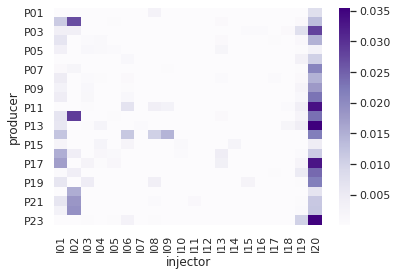

In [79]:
data = gains_sample.groupby(["producer", "injector"])["Gain"].mean().unstack()
sns.heatmap(data, cmap="Purples")
data.sum()

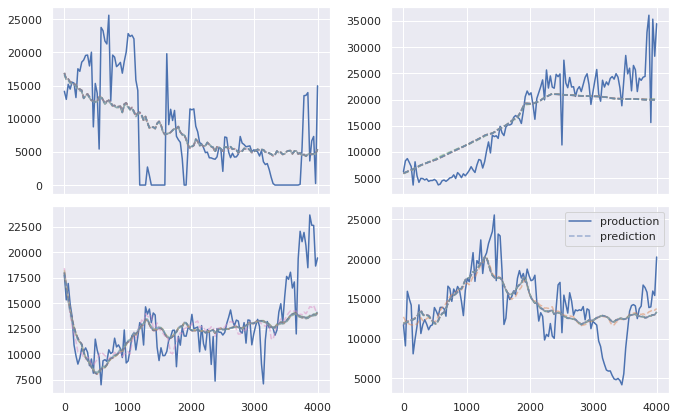

In [74]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(6 * 1.6, 6))
for i, well in enumerate([0, 1, 3, 6]):
    ax = axes.flatten()[i]
    ax.plot(time, production[:, well], label="production")
    for crm in crms:
        q_hat = crm.predict()
        if crm == crms[-1]:
            label = "prediction"
        else:
            label = None
        ax.plot(time, q_hat[:, well], "--", label=label, alpha=0.5)
ax.legend()
fig.tight_layout()
# fig.legend()

In [13]:
%%time
constrainer = "sum-to-one injector"


def init_and_fit(i):
    print(i)
    crm = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
    crm.fit(production, injection, time, random=True)
    return crm


crms = [init_and_fit(i) for i in range(10)]

# crms2 = Parallel(n_jobs=8)(delayed(init_and_fit)(i) for i in range(8))

Wall time: 3min 33s


In [38]:
[c.results["fun"] for c in crms]

[DeviceArray(1.479525e+11, dtype=float32),
 DeviceArray(1.4803619e+11, dtype=float32),
 DeviceArray(1.4797098e+11, dtype=float32),
 DeviceArray(1.4785521e+11, dtype=float32),
 DeviceArray(1.479224e+11, dtype=float32),
 DeviceArray(1.4786486e+11, dtype=float32),
 DeviceArray(1.480159e+11, dtype=float32),
 DeviceArray(1.4812296e+11, dtype=float32),
 DeviceArray(1.4787853e+11, dtype=float32),
 DeviceArray(1.4796317e+11, dtype=float32)]

In [9]:
successes = [crm.results.success for crm in crms]
successes

[False, False, False, False, False, False, False, False]

In [37]:
# gains_sample.to_csv('results/Senlac_20runs_gains.csv')

In [7]:
gains_sample.describe()

,Gain,Tau,log_gain
count,4600.000000,4600.000000,4600.000000
mean,2.304201,30.500086,-0.507859
std,3.149792,0.000129,1.078076
min,0.000013,30.500000,-4.888483
25%,0.047064,30.500000,-1.327308
50%,0.091362,30.500036,-1.039235
75%,4.615239,30.500123,0.664194
max,12.575840,30.501707,1.099537


In [9]:
temp

mean       sem
producer injector                    
P01      I01       0.057871  0.008235
         I02       1.288028  0.064918
         I03       0.043135  0.008313
         I04       0.053383  0.008474
         I05       0.043394  0.011095
...                     ...       ...
P23      I16       6.954648  0.133263
         I17       7.756316  0.127767
         I18       8.331591  0.197882
         I19       8.984082  0.211722
         I20       9.127051  0.164595

[460 rows x 2 columns]

[Text(18.875, 0.5, 'Standard error(gain)'),
 Text(0.5, 30.49999999999995, 'Sample mean(gain)')]

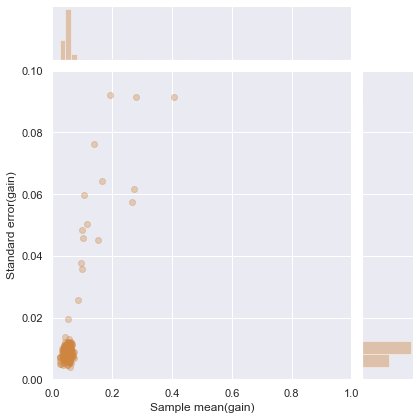

In [10]:
temp = gains_sample.groupby(["producer", "injector"])["Gain"].agg(["mean", "sem"])
temp.to_csv("results/Senlac_averages.csv")

g = sns.jointplot(
    x="mean",
    y="sem",
    data=temp[temp["mean"] < 1],
    xlim=(0, None),
    ylim=(0, 0.1),
    alpha=0.33,
    color="peru",
)

g.ax_joint.set(xlabel="Sample mean(gain)", ylabel="Standard error(gain)")

In [63]:
temp.query("mean > 0").query("sem > mean")

mean       sem
producer injector                    
P03      I20       0.000073  0.000073
P05      I03       0.010625  0.010625
         I08       0.001914  0.001914
P13      I20       0.003077  0.003077

In [7]:
gains = pd.DataFrame(columns=inj.columns, index=prod.columns, data=crm.gains)
taus = pd.DataFrame(columns=inj.columns, index=prod.columns, data=crm.tau)
gains_producer = pd.Series(index=prod.columns, data=crm.gains_producer)
taus_producer = pd.Series(index=prod.columns, data=crm.tau_producer)

gains.columns.name = "injector"
gains.index.name = "producer"
taus.columns.name = "injector"
taus.index.name = "producer"

In [8]:
locations = pd.read_excel("data/Seminole XY.xlsx")[["UWI", "XCOORD", "YCOORD"]]
locations = locations[locations.UWI.apply(len) == 10].rename(
    columns={"XCOORD": "x", "YCOORD": "y"}
)
locations["UWI"] = locations["UWI"].astype(np.int64)
locations = locations.set_index("UWI")
locations.head()

,x,y
UWI,,
4216500019,393752.8,439160.8
4216500022,404153.3,434501.4
4216500023,397019.0,449603.8
4216500024,388882.4,447319.6
4216500025,401474.8,434760.2


In [15]:
well_pairs = (
    pd.concat([gains.stack().rename("Gain"), taus.stack().rename("Tau")], axis=1)
    .reset_index()
    .assign(log_gain=lambda x: np.log10(x.Gain))
)
for d in ("x", "y"):
    well_pairs[d + "_distance"] = (
        locations.loc[well_pairs["producer"], d].values
        - locations.loc[well_pairs["injector"], d].values
    )
well_pairs["distance"] = (
    np.sqrt((well_pairs[["x_distance", "y_distance"]] ** 2).sum(axis=1)) / 5280
)
well_pairs["azimuth"] = np.arctan2(well_pairs["x_distance"], well_pairs["y_distance"])

well_pairs.to_csv("results/Senlac_pairs.csv", index=False)
# well_pairs['distance'] = well_pairs.apply(distance, locations=locations, axis=1) / 5280
# well_pairs['azimuth'] = well_pairs.apply(azimuth, locations=locations, axis=1)
# well_pairs_full = well_pairs.copy()
# well_pairs = well_pairs[well_pairs.Gain>1e-5]

In [59]:
from numpy.random import default_rng

rng = default_rng()
n, p = 50, 0.01

s = rng.binomial(n, p, 100_000) / n

 the mean is 0.010 and the standard error is 0.001996227622291606


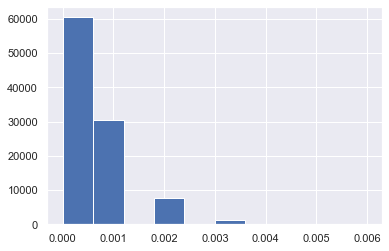

In [61]:
plt.hist(s / 20)
print(
    f" the mean is {np.mean(s):.3f} and the standard error is { np.std(s)/np.sqrt(n)}"
)

<ipython-input-9-090fbb653350>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


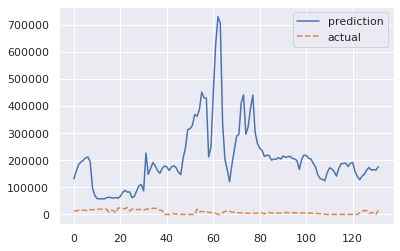

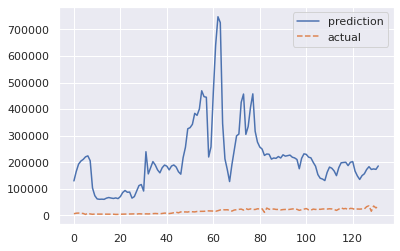

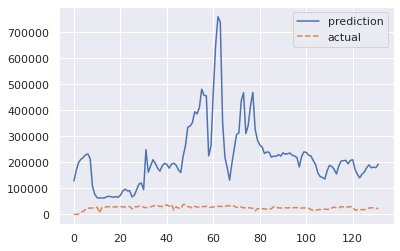

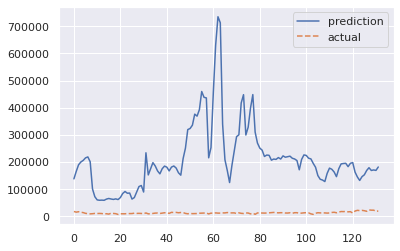

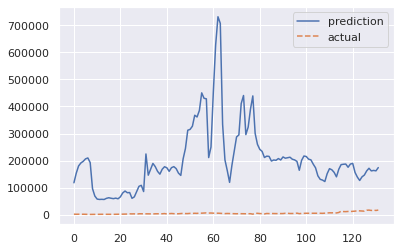

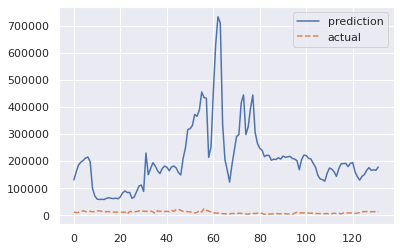

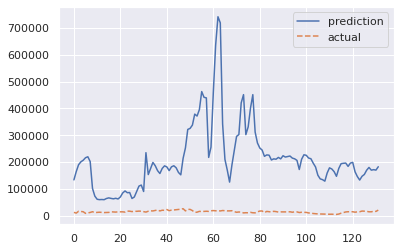

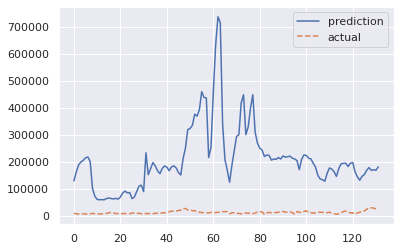

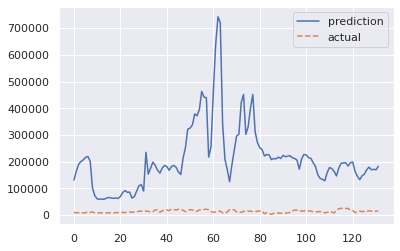

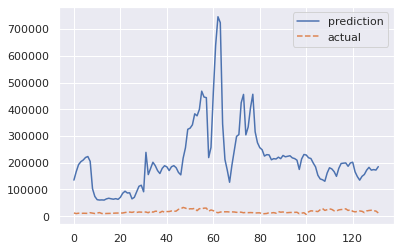

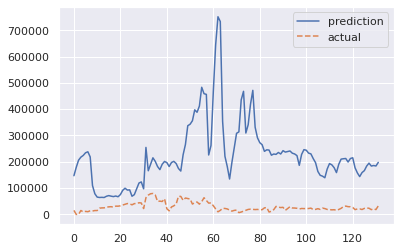

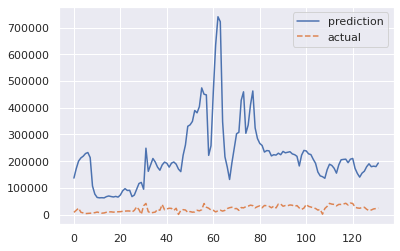

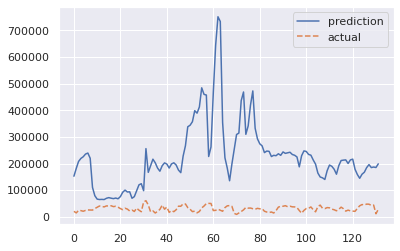

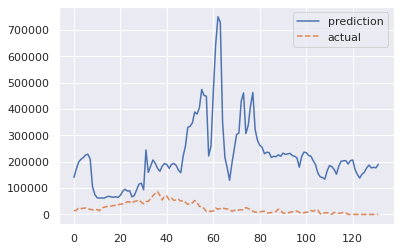

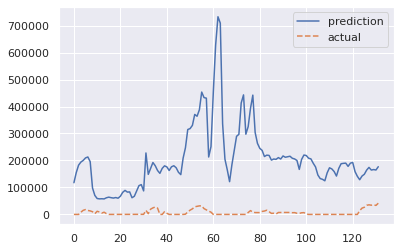

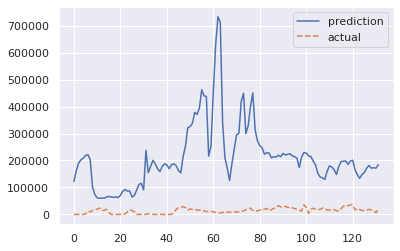

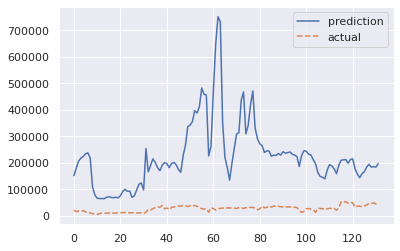

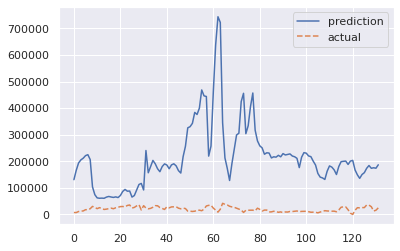

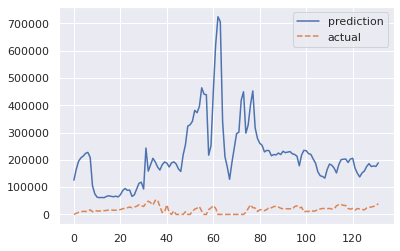

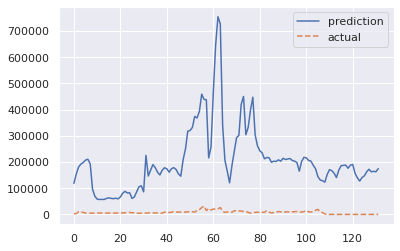

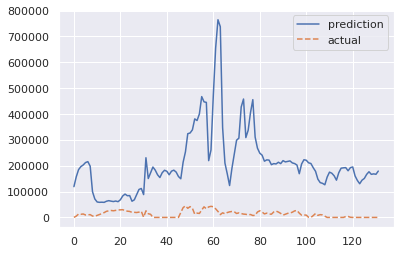

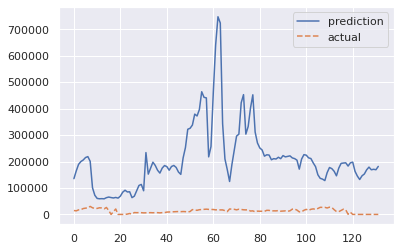

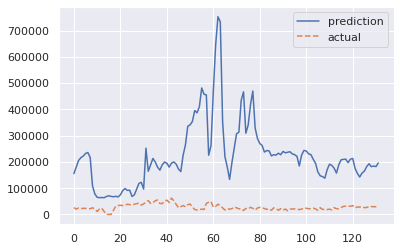

In [9]:
q_hat = crm.predict()
# q_hat = crms2[0].predict()

for i in range(q_hat.shape[1]):
    plt.figure()
    plt.plot(q_hat[:, i], label="prediction")
    plt.plot(production[:, i], "--", label="actual")
    plt.legend(loc="best")